In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()

In [2]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
df.shape

(20640, 9)

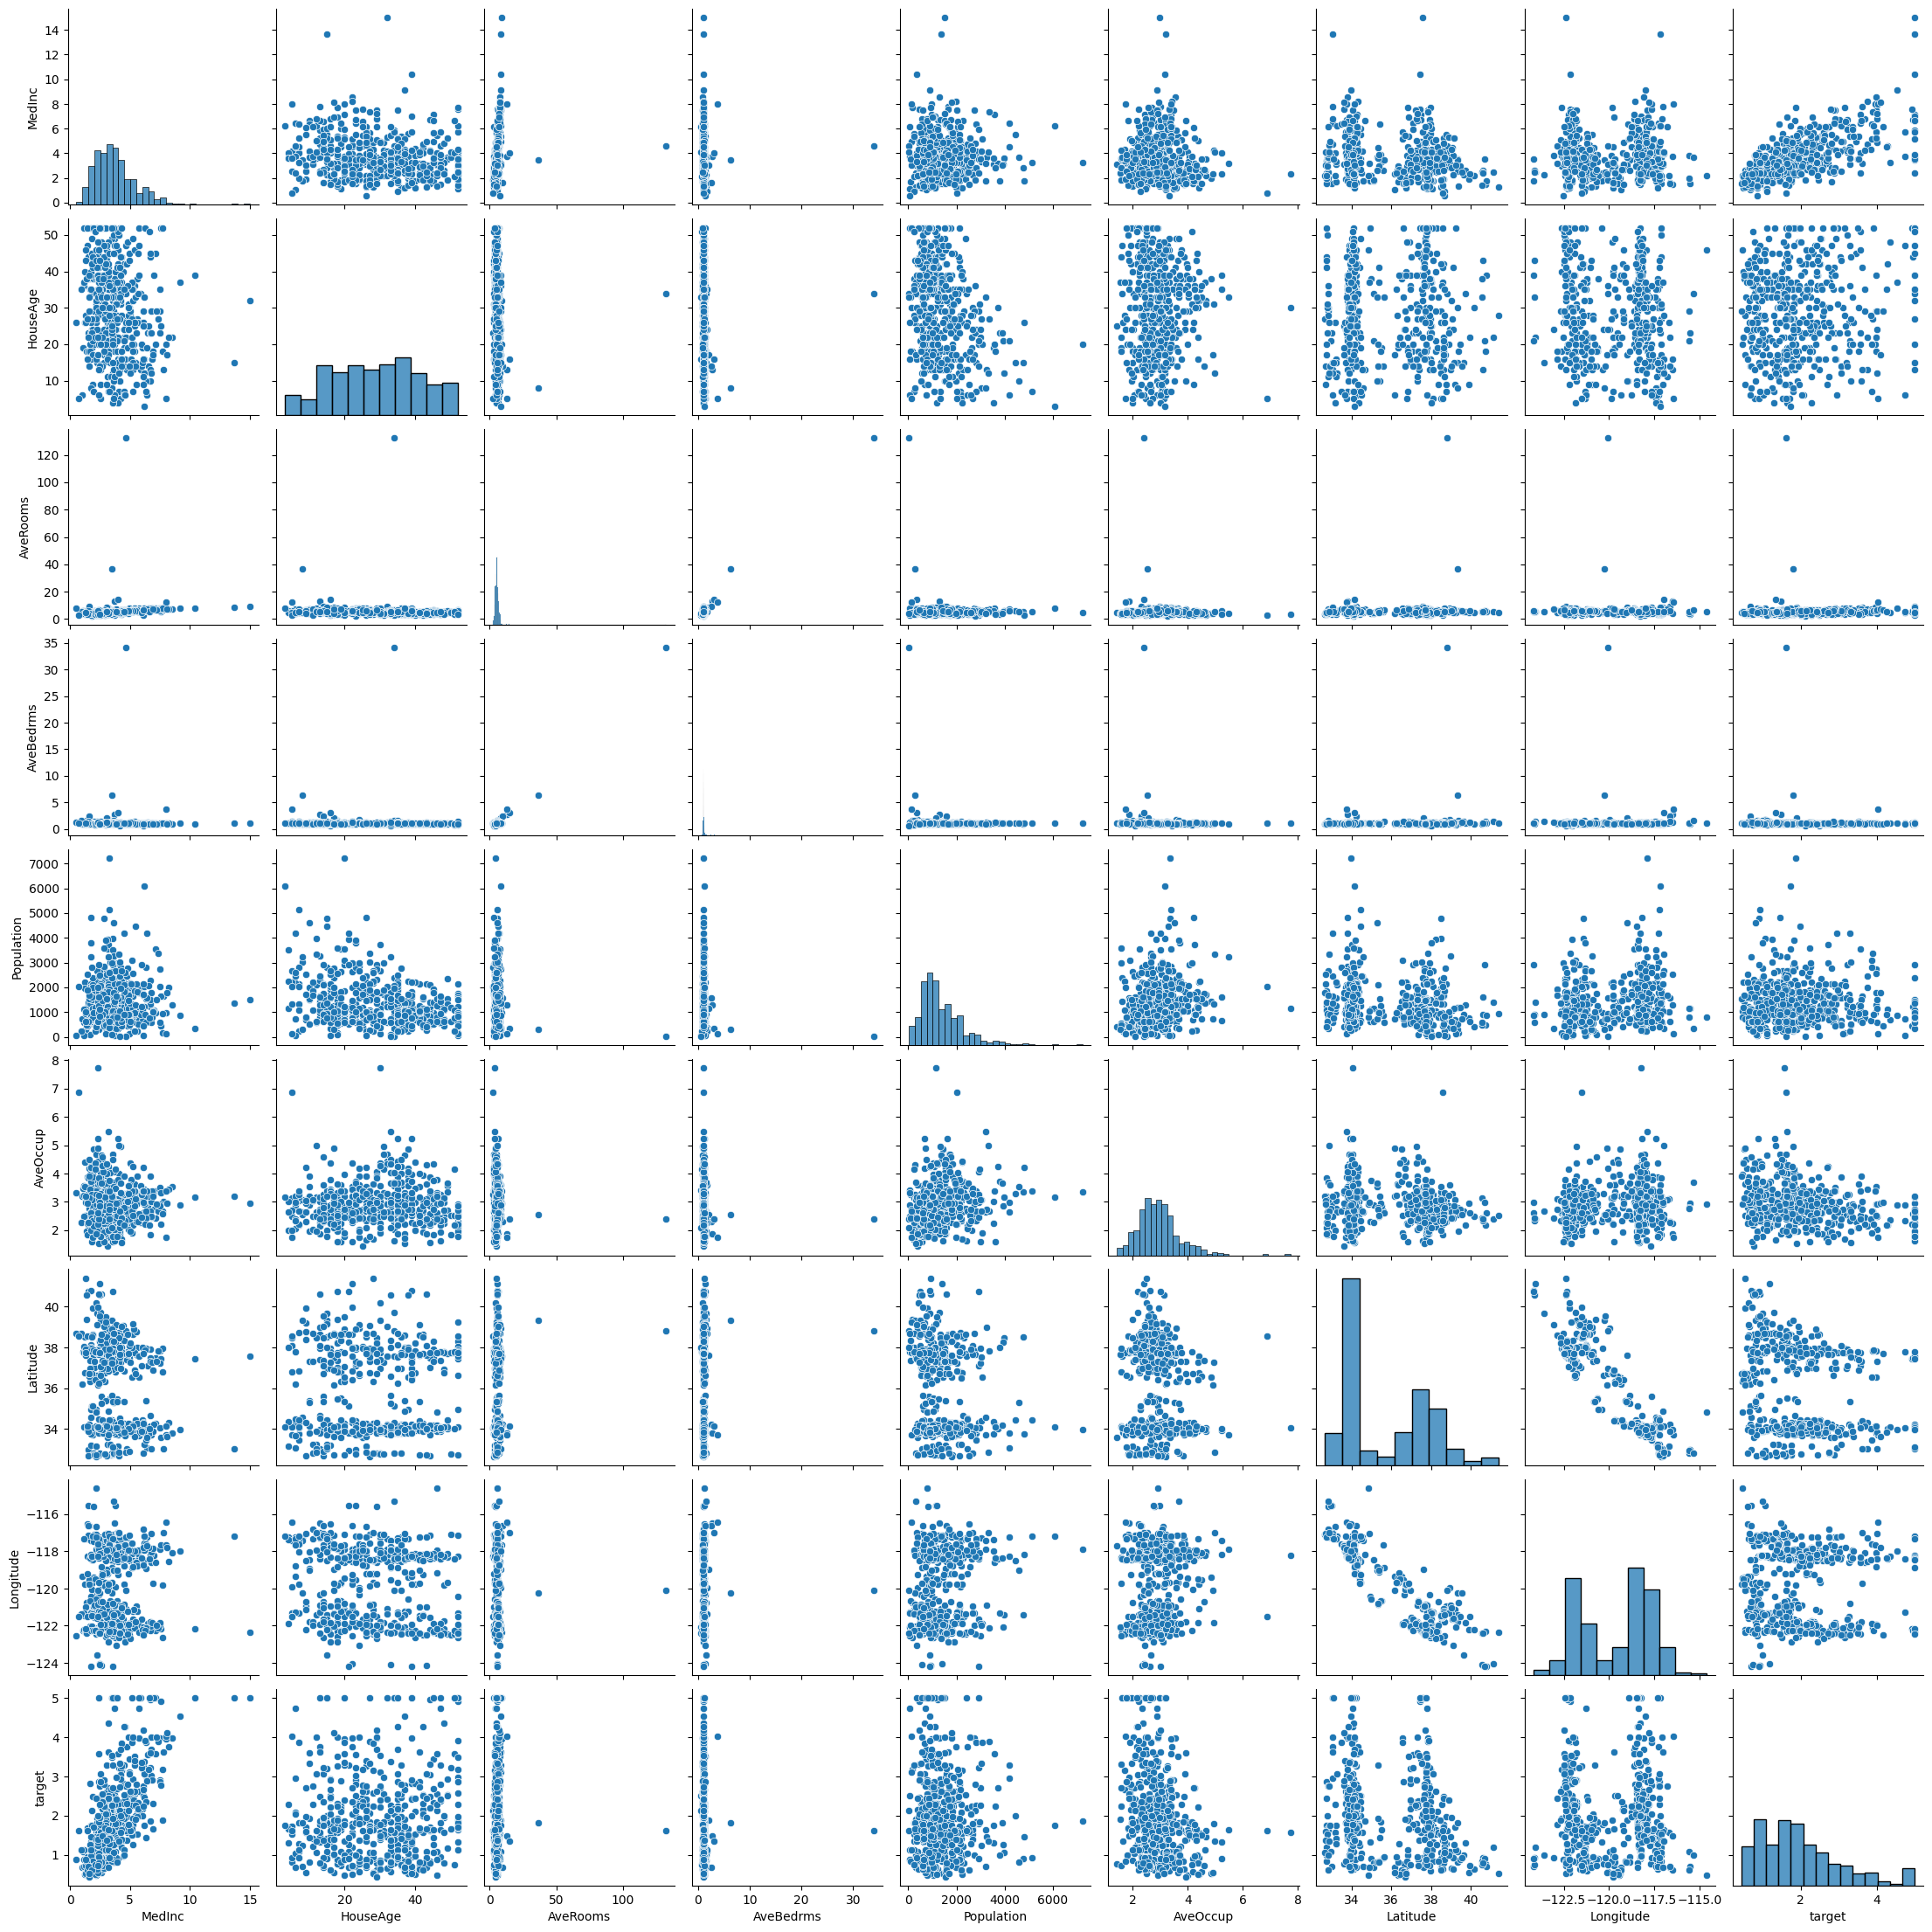

In [5]:
sns.pairplot(df.sample(500))
plt.show()

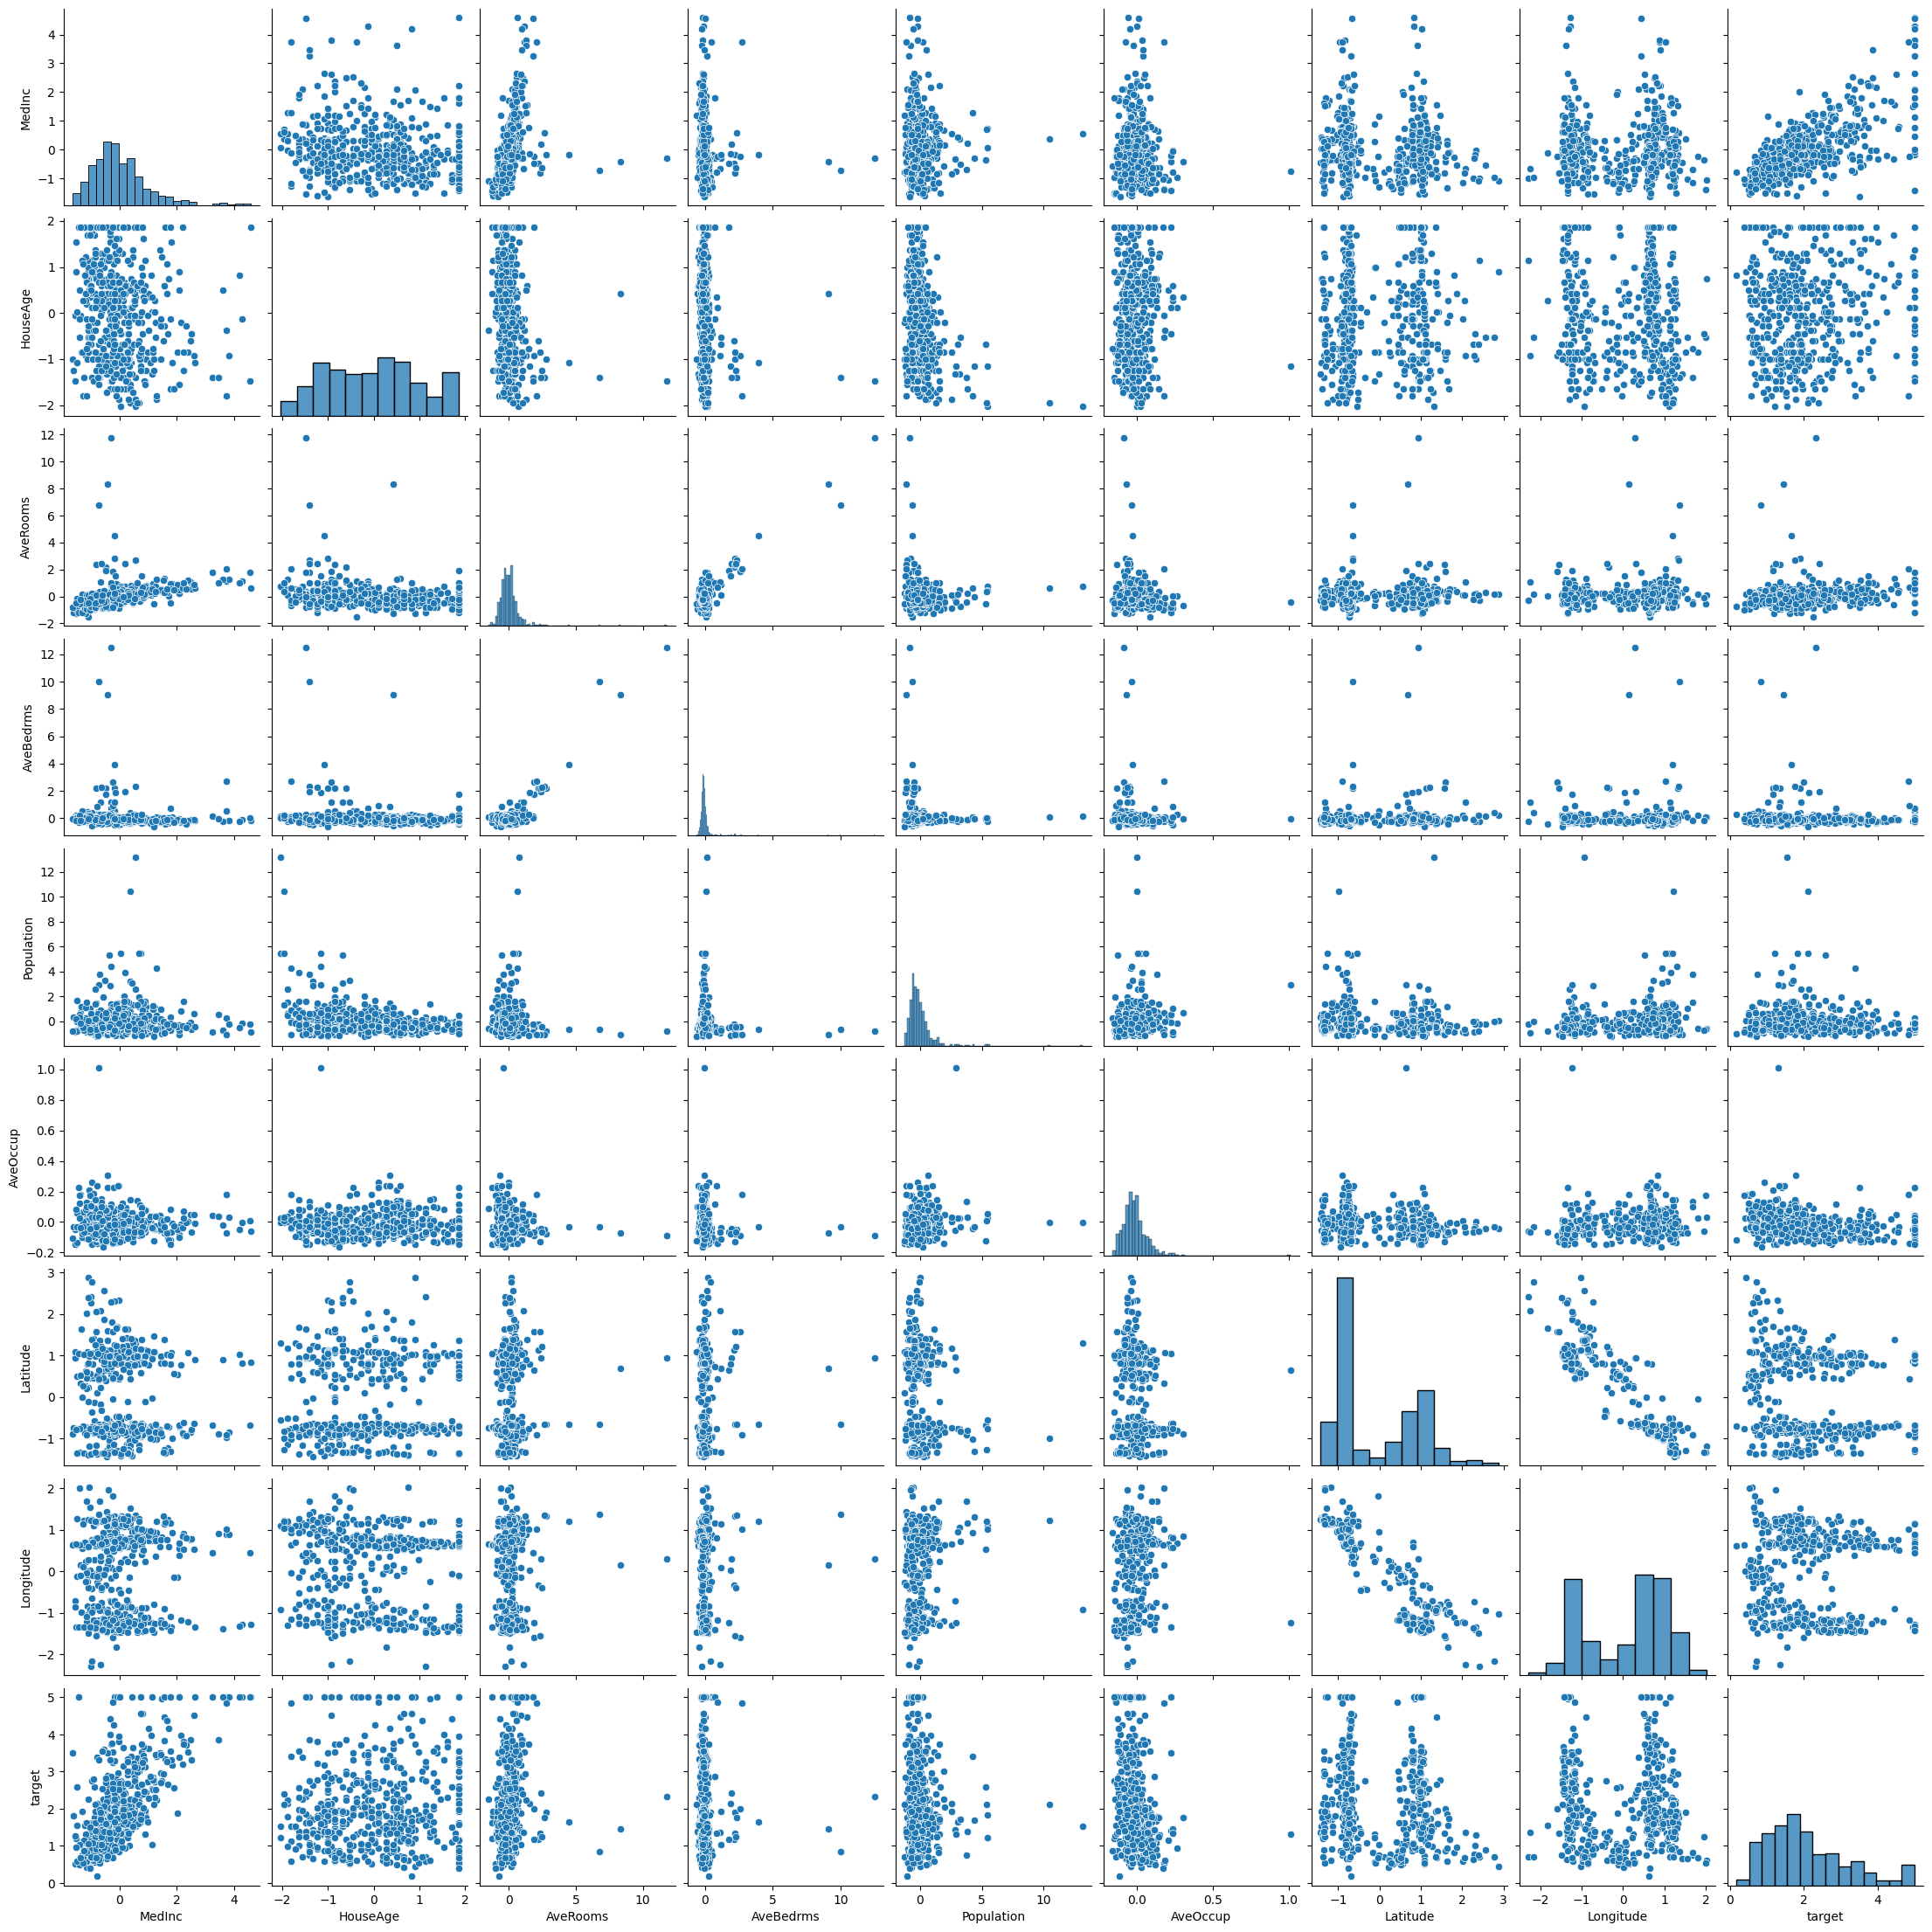

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values[:, :-1])
df.values[:, :-1] = X_scaled

## Scaling 후 시각화 다시
sns.pairplot(df.sample(500))
plt.show()

In [7]:
## torch 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
## dataset -> Tensor

data = torch.from_numpy(df.values).float()

data.shape

torch.Size([20640, 9])

In [26]:
## Features / Target Variable 구분

X = data[:, :-1]
y = data[:, -1:]

print(f'X shape : {X.shape}\ny Shape : {y.shape}')

X shape : torch.Size([20640, 8])
y Shape : torch.Size([20640, 1])


In [31]:
## 학습에 필요한 세팅

n_epochs = 4000
batch_size= 256
print_interval = 400
learning_rate = 1e-3

model = nn.Sequential(
    nn.Linear(X.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1))
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [32]:
optimizer = optim.SGD(model.parameters(), 
                    lr=learning_rate,)

In [33]:
y

tensor([[4.5260],
        [3.5850],
        [3.5210],
        ...,
        [0.9230],
        [0.8470],
        [0.8940]])

In [34]:
## Minibatch Train

for i in range(n_epochs):
    # 각 epoch에 랜덤하게 인덱스 뽑기
    indices = torch.randperm(X.size(0)) 
    
    x_ = torch.index_select(X, dim = 0, index = indices)
    y_ = torch.index_select(y, dim = 0, index = indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []  ## 마지막 epochs 끝난 후 사용할 변수 저장
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]| / |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad() # gradient 초기화
        loss.backward()       # gradient 계산
        optimizer.step()      # Updating

        total_loss += float(loss)
        y_hat += [y_hat_i]


    total_loss = total_loss / len(x_)

    if (i+1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i+1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)



Epoch 400: loss=3.8309e-01
Epoch 800: loss=3.6133e-01
Epoch 1200: loss=3.4796e-01
Epoch 1600: loss=3.3426e-01
Epoch 2000: loss=3.2245e-01
Epoch 2400: loss=3.1470e-01
Epoch 2800: loss=3.1211e-01
Epoch 3200: loss=3.0873e-01
Epoch 3600: loss=3.0635e-01
Epoch 4000: loss=3.0450e-01


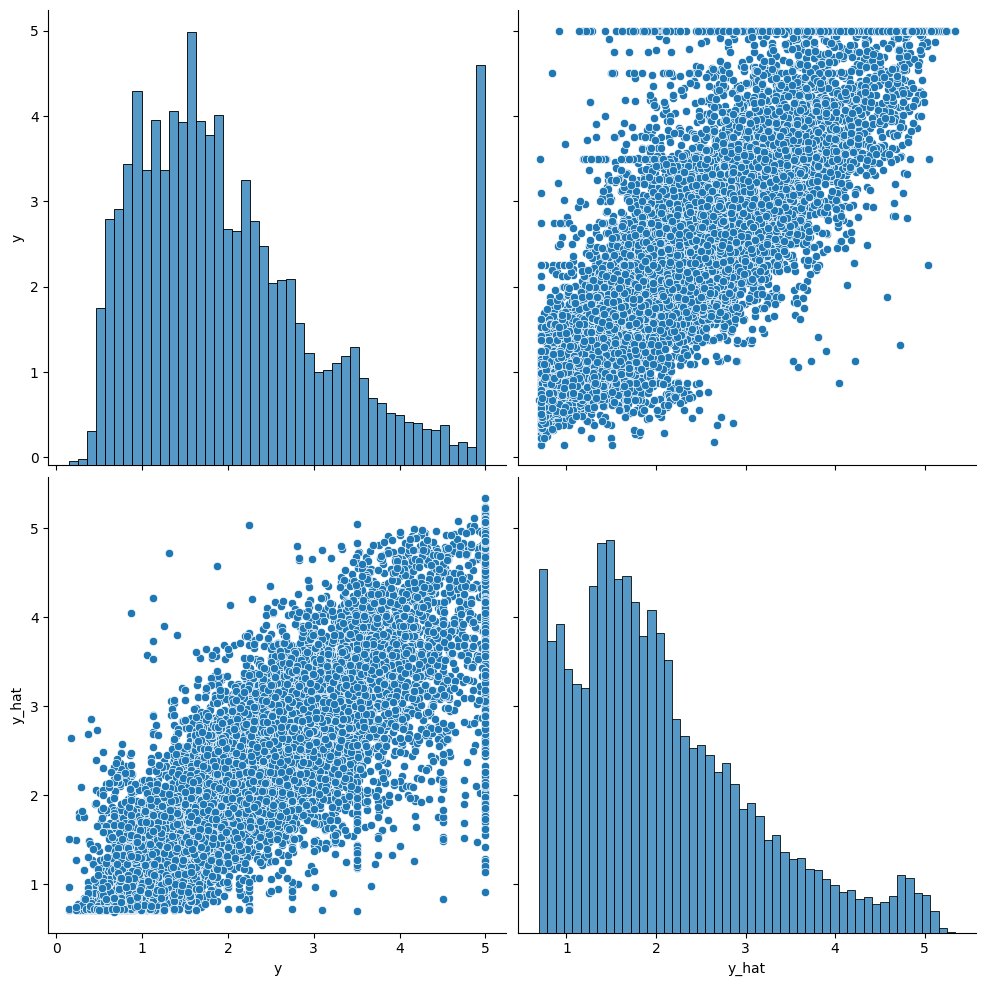

In [35]:
result = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat'])

sns.pairplot(result, height=5)
plt.show()